# Nutritional Data Mining & Processing
## Open Food Facts Dataset for NutriFoodBot Project

This notebook performs comprehensive nutritional data analysis focusing on:
- Nutrient extraction from complex nested structures (109+ nutrients identified)
- Standardization of nutritional values per 100g serving
- Macro and micronutrient completeness assessment
- Nutritional data validation and outlier detection
- Creation of nutritional profiles and feature vectors
- Nutrient correlation analysis and dependency mapping
- Missing nutrient imputation strategies

**Analysis #2 from NutriFoodBot EDA Roadmap**

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datasets import load_dataset
import json
import ast
from typing import Dict, List, Tuple, Any, Optional
from collections import defaultdict, Counter
import re
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import gc
import sys

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Python version: 3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]
Pandas version: 2.3.1
NumPy version: 2.3.1


## 1. Data Loading and Initial Setup

In [2]:
# Load dataset (using 2% sample for detailed nutritional analysis)
print("Loading 2% sample for detailed nutritional analysis...")
dataset = load_dataset("parquet", data_files="food.parquet", split="train[:2%]")
df = dataset.to_pandas()

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Focus on nutritional columns for this analysis
nutritional_columns = [
    'nutriments', 'nutrition_data_per', 'no_nutrition_data', 
    'nutriscore_grade', 'nutriscore_score', 'nova_group',
    'serving_size', 'serving_quantity', 'product_quantity',
    'minerals_tags', 'vitamins_tags', 'nucleotides_tags',
    'nutrient_levels_tags', 'unknown_nutrients_tags'
]

available_nutrition_cols = [col for col in nutritional_columns if col in df.columns]
print(f"\nAvailable nutritional columns ({len(available_nutrition_cols)}):")
for col in available_nutrition_cols:
    print(f"  - {col}")

Loading 2% sample for detailed nutritional analysis...
Dataset shape: (78382, 110)
Memory usage: 1042.40 MB

Available nutritional columns (14):
  - nutriments
  - nutrition_data_per
  - no_nutrition_data
  - nutriscore_grade
  - nutriscore_score
  - nova_group
  - serving_size
  - serving_quantity
  - product_quantity
  - minerals_tags
  - vitamins_tags
  - nucleotides_tags
  - nutrient_levels_tags
  - unknown_nutrients_tags


## 2. Nutrient Extraction from Complex Nested Structures

In [3]:
def extract_nutrients_from_nutriments(nutriments_series: pd.Series) -> pd.DataFrame:
    """
    Extract individual nutrients from the complex nutriments nested structure
    The data format is numpy arrays containing dictionaries with nutrient information
    """
    print("Extracting nutrients from nutriments column...")
    
    all_nutrients = defaultdict(list)
    nutrient_units = defaultdict(set)
    processed_count = 0
    error_count = 0
    
    # Show first few samples to understand structure
    sample_nutriments = nutriments_series.dropna().head(3)
    print(f"Data structure analysis:")
    for idx, nutriments in sample_nutriments.items():
        print(f"  Sample {idx}: {type(nutriments)} with {len(nutriments) if hasattr(nutriments, '__len__') else 'N/A'} items")
        if hasattr(nutriments, '__len__') and len(nutriments) > 0:
            print(f"    First item: {nutriments[0]}")
    
    print(f"\nProcessing all {len(nutriments_series)} entries...")
    
    for idx, nutriments in nutriments_series.items():
        # Handle missing values
        if nutriments is None:
            continue
        if isinstance(nutriments, float) and np.isnan(nutriments):
            continue
            
        try:
            # The nutriments column contains numpy arrays of dictionaries
            if isinstance(nutriments, np.ndarray):
                # Process each nutrient dictionary in the array
                for nutrient_dict in nutriments:
                    if isinstance(nutrient_dict, dict):
                        # Extract nutrient name
                        nutrient_name = nutrient_dict.get('name')
                        if not nutrient_name:
                            continue
                        
                        # Extract the 100g value (standardized per 100g)
                        value_100g = nutrient_dict.get('100g')
                        if value_100g is not None and not (isinstance(value_100g, float) and np.isnan(value_100g)):
                            all_nutrients[nutrient_name].append((idx, float(value_100g)))
                        else:
                            # Fallback to 'value' if 100g is not available
                            value = nutrient_dict.get('value')
                            if value is not None and not (isinstance(value, float) and np.isnan(value)):
                                all_nutrients[nutrient_name].append((idx, float(value)))
                        
                        # Extract unit information
                        unit = nutrient_dict.get('unit')
                        if unit and isinstance(unit, str):
                            nutrient_units[nutrient_name].add(unit)
            else:
                error_count += 1
                continue
            
            processed_count += 1
            if processed_count % 10000 == 0:
                print(f"  Processed {processed_count} products...")
                
        except Exception as e:
            error_count += 1
            if error_count <= 5:  # Show first few errors
                print(f"  Error processing entry {idx}: {e}")
            continue
    
    print(f"Successfully processed {processed_count} products")
    print(f"Errors encountered: {error_count}")
    print(f"Found {len(all_nutrients)} unique nutrients")
    
    if len(all_nutrients) > 0:
        print("Top 15 most common nutrients:")
        nutrient_counts = {k: len(v) for k, v in all_nutrients.items()}
        sorted_nutrients = sorted(nutrient_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (nutrient, count) in enumerate(sorted_nutrients[:15], 1):
            unit = list(nutrient_units.get(nutrient, [''])) if nutrient in nutrient_units else ['']
            print(f"  {i:2d}. {nutrient:<55} | {count:>6,} products | {unit[0]:<4}")
    
    # Create DataFrame with extracted nutrients
    nutrients_df = pd.DataFrame(index=nutriments_series.index)
    
    for nutrient, values in all_nutrients.items():
        if len(values) >= 10:  # Only include nutrients with at least 10 observations
            nutrient_series = pd.Series(index=nutriments_series.index, dtype='float64')
            for idx, value in values:
                nutrient_series.loc[idx] = value
            nutrients_df[nutrient] = nutrient_series
    
    # Store unit information
    unit_info = {nutrient: list(units) for nutrient, units in nutrient_units.items() if units}
    
    return nutrients_df, unit_info

# Extract nutrients from the nutriments column
if 'nutriments' in df.columns:
    nutrients_df, nutrient_units_info = extract_nutrients_from_nutriments(df['nutriments'])
    
    print(f"\n" + "="*60)
    print("NUTRIENT EXTRACTION RESULTS")
    print("="*60)
    print(f"Extracted nutrients shape: {nutrients_df.shape}")
    
    if len(nutrients_df.columns) > 0:
        print(f"Successfully extracted {len(nutrients_df.columns)} nutrients")
        print(f"Sample nutrient columns: {list(nutrients_df.columns[:10])}")
        
        # Show unit information for key nutrients
        print(f"\nUnit information for key nutrients:")
        key_nutrients = ['energy', 'proteins', 'fat', 'carbohydrates', 'sugars', 'fiber', 'salt', 'sodium']
        for nutrient in key_nutrients:
            if nutrient in nutrient_units_info:
                print(f"  {nutrient:<15}: {nutrient_units_info[nutrient]}")
            elif nutrient in nutrients_df.columns:
                print(f"  {nutrient:<15}: [no unit info]")
        
        # Show data completeness for extracted nutrients
        print(f"\nData completeness for extracted nutrients:")
        completeness = (nutrients_df.notna().sum() / len(nutrients_df)) * 100
        print(f"  Average completeness: {completeness.mean():.1f}%")
        print(f"  Most complete nutrient: {completeness.idxmax()} ({completeness.max():.1f}%)")
        print(f"  Least complete nutrient: {completeness.idxmin()} ({completeness.min():.1f}%)")
        
    else:
        print("❌ No nutrients were successfully extracted")
        print("The nutriment data format may still be different than expected.")
else:
    print("Nutriments column not found in dataset")
    nutrients_df = pd.DataFrame()

Extracting nutrients from nutriments column...
Data structure analysis:
  Sample 0: <class 'numpy.ndarray'> with 12 items
    First item: {'name': 'saturated-fat', 'value': 10.0, '100g': 10.0, 'serving': None, 'unit': 'g', 'prepared_value': None, 'prepared_100g': None, 'prepared_serving': None, 'prepared_unit': None}
  Sample 1: <class 'numpy.ndarray'> with 11 items
    First item: {'name': 'fruits-vegetables-legumes-estimate-from-ingredients', 'value': None, '100g': 100.0, 'serving': 100.0, 'unit': None, 'prepared_value': None, 'prepared_100g': None, 'prepared_serving': None, 'prepared_unit': None}
  Sample 2: <class 'numpy.ndarray'> with 11 items
    First item: {'name': 'sodium', 'value': 4.0, '100g': 0.004000000189989805, 'serving': 0.0017999999690800905, 'unit': 'mg', 'prepared_value': None, 'prepared_100g': None, 'prepared_serving': None, 'prepared_unit': None}

Processing all 78382 entries...
  Processed 10000 products...
  Processed 20000 products...
  Processed 30000 products.

In [4]:
# Analyze the most common and complete nutrients
if not nutrients_df.empty:
    nutrient_completeness = (nutrients_df.notna().sum() / len(nutrients_df)) * 100
    nutrient_completeness = nutrient_completeness.sort_values(ascending=False)
    
    print(f"Top 20 most complete nutrients:")
    for i, (nutrient, completeness) in enumerate(nutrient_completeness.head(20).items(), 1):
        count = nutrients_df[nutrient].notna().sum()
        print(f"{i:2d}. {nutrient:55s} | {completeness:6.1f}% complete | {count:,} products")
    
    # Categorize nutrients by type
    def categorize_nutrients(nutrient_names: List[str]) -> Dict[str, List[str]]:
        categories = {
            'macronutrients': [],
            'vitamins': [],
            'minerals': [],
            'fatty_acids': [],
            'amino_acids': [],
            'other': []
        }
        
        for nutrient in nutrient_names:
            nutrient_lower = nutrient.lower()
            
            # Macronutrients
            if any(term in nutrient_lower for term in ['energy', 'protein', 'fat', 'carbohydrate', 'sugar', 'fiber', 'salt', 'sodium']):
                categories['macronutrients'].append(nutrient)
            # Vitamins
            elif any(term in nutrient_lower for term in ['vitamin', 'folate', 'niacin', 'thiamin', 'riboflavin', 'pantothenic', 'biotin']):
                categories['vitamins'].append(nutrient)
            # Minerals
            elif any(term in nutrient_lower for term in ['calcium', 'iron', 'magnesium', 'phosphorus', 'potassium', 'zinc', 'copper', 'manganese', 'selenium', 'iodine', 'chromium', 'molybdenum']):
                categories['minerals'].append(nutrient)
            # Fatty acids
            elif any(term in nutrient_lower for term in ['fatty', 'saturated', 'monounsaturated', 'polyunsaturated', 'trans', 'omega', 'linoleic', 'linolenic']):
                categories['fatty_acids'].append(nutrient)
            # Amino acids
            elif any(term in nutrient_lower for term in ['amino', 'leucine', 'isoleucine', 'valine', 'lysine', 'methionine', 'threonine', 'tryptophan', 'phenylalanine', 'histidine']):
                categories['amino_acids'].append(nutrient)
            else:
                categories['other'].append(nutrient)
        
        return categories
    
    nutrient_categories = categorize_nutrients(nutrients_df.columns.tolist())
    
    print(f"\nNutrient categorization:")
    for category, nutrients in nutrient_categories.items():
        if nutrients:
            print(f"\n{category.upper().replace('_', ' ')} ({len(nutrients)} nutrients):")
            for nutrient in nutrients:  # Show first 10 of each category
                completeness = nutrient_completeness.get(nutrient, 0)
                print(f"  - {nutrient:55s} ({completeness:5.1f}% complete)")

Top 20 most complete nutrients:
 1. energy                                                  |   98.3% complete | 77,066 products
 2. carbohydrates                                           |   98.3% complete | 77,017 products
 3. fat                                                     |   98.2% complete | 76,995 products
 4. proteins                                                |   98.2% complete | 76,979 products
 5. energy-kcal                                             |   98.0% complete | 76,849 products
 6. sodium                                                  |   97.1% complete | 76,087 products
 7. salt                                                    |   97.1% complete | 76,087 products
 8. fruits-vegetables-legumes-estimate-from-ingredients     |   95.8% complete | 75,070 products
 9. fruits-vegetables-nuts-estimate-from-ingredients        |   95.8% complete | 75,070 products
10. sugars                                                  |   93.3% complete | 73,093 product

## 3. Standardization of Nutritional Values per 100g Serving

In [5]:
def standardize_nutritional_values(nutrients_df: pd.DataFrame, main_df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize nutritional values to per 100g serving
    """
    print("Standardizing nutritional values to per 100g serving...")
    
    # Check nutrition_data_per column to understand current units
    if 'nutrition_data_per' in main_df.columns:
        per_values = main_df['nutrition_data_per'].value_counts()
        print(f"\nNutrition data per values:")
        for value, count in per_values.head(10).items():
            print(f"  {value}: {count:,} products")
        
        # Calculate standardization factors
        standardization_needed = main_df['nutrition_data_per'] != '100g'
        print(f"\nProducts needing standardization: {standardization_needed.sum():,} ({(standardization_needed.sum()/len(main_df))*100:.1f}%)")
    
    # Create standardized version - THIS IS THE CRITICAL PART
    print("\n🔧 APPLYING STANDARDIZATION LOGIC:")
    standardized_df = nutrients_df.copy()
    
    # Apply standardization based on serving information
    if 'serving_size' in main_df.columns:
        serving_info = main_df['serving_size'].dropna()
        print(f"Products with serving_size data: {len(serving_info):,}")
        
        # Extract numeric values from serving size - FIXED REGEX PATTERN
        serving_numeric = []
        serving_sizes_dict = {}
        failed_extractions = []
        
        for idx, serving in serving_info.items():
            if isinstance(serving, str):
                # Extract numbers from serving size string - CORRECT REGEX
                numbers = re.findall(r'\d+(?:\.\d+)?', serving)
                if numbers:
                    serving_g = float(numbers[0])
                    serving_numeric.append(serving_g)
                    serving_sizes_dict[idx] = serving_g
                else:
                    failed_extractions.append(serving)
        
        print(f"✅ Successfully extracted {len(serving_sizes_dict):,} numeric serving sizes")
        if failed_extractions:
            unique_failures = list(set(failed_extractions))
            print(f"⚠️  Failed to extract {len(failed_extractions)} serving sizes (non-numeric entries like '{unique_failures[0]}')")
        
        if serving_numeric:
            print(f"Serving size statistics - Mean: {np.mean(serving_numeric):.1f}g, Median: {np.median(serving_numeric):.1f}g")
            
            # Analyze which per-serving products can be standardized
            per_serving_products = main_df[main_df['nutrition_data_per'] == 'serving'].index
            per_serving_with_sizes = [idx for idx in per_serving_products if idx in serving_sizes_dict]
            per_serving_without_sizes = [idx for idx in per_serving_products if idx not in serving_sizes_dict]
            
            # Break down why some can't be standardized
            per_serving_no_serving_data = []
            per_serving_bad_serving_data = []
            for idx in per_serving_without_sizes:
                if pd.isna(main_df.loc[idx, 'serving_size']):
                    per_serving_no_serving_data.append(idx)
                else:
                    per_serving_bad_serving_data.append(idx)
            
            print(f"\nStandardization feasibility analysis:")
            print(f"  Per-serving products requiring standardization: {len(per_serving_products):,}")
            print(f"  - Can be standardized (have numeric serving sizes): {len(per_serving_with_sizes):,}")
            print(f"  - Cannot be standardized: {len(per_serving_without_sizes):,}")
            print(f"    • Missing serving_size data: {len(per_serving_no_serving_data):,}")
            print(f"    • Non-numeric serving_size data: {len(per_serving_bad_serving_data):,}")
            
            # NOW ACTUALLY STANDARDIZE THE DATA
            standardization_count = 0
            debug_conversions = []
            
            for idx in per_serving_with_sizes:
                serving_size_g = serving_sizes_dict[idx]
                
                if serving_size_g > 0:  # Avoid division by zero
                    # Calculate conversion factor: (100g / serving_size_g)
                    conversion_factor = 100.0 / serving_size_g
                    
                    # Store before conversion for verification (first few examples)
                    if standardization_count < 5 and 'energy' in standardized_df.columns:
                        original_energy = standardized_df.loc[idx, 'energy']
                        if pd.notna(original_energy):
                            debug_conversions.append({
                                'idx': idx,
                                'serving_size': serving_size_g,
                                'conversion_factor': conversion_factor,
                                'original_energy': original_energy
                            })
                    
                    # Apply conversion to all nutrients for this product
                    for nutrient in standardized_df.columns:
                        if pd.notna(standardized_df.loc[idx, nutrient]):
                            standardized_df.loc[idx, nutrient] *= conversion_factor
                    
                    standardization_count += 1
            
            print(f"✅ Successfully standardized {standardization_count:,} products from per-serving to per-100g")
            
            # Verify standardization worked with actual examples
            if debug_conversions:
                print(f"\n🔍 STANDARDIZATION VERIFICATION:")
                print(f"Sample conversions (per-serving → per-100g):")
                for conversion in debug_conversions:
                    idx = conversion['idx']
                    serving_size = conversion['serving_size']
                    original_energy = conversion['original_energy']
                    standardized_energy = standardized_df.loc[idx, 'energy']
                    
                    print(f"    Product {idx}: {serving_size}g serving")
                    print(f"      Energy: {original_energy:.1f} → {standardized_energy:.1f} kcal/100g (×{100/serving_size:.1f})")
        else:
            print("❌ No serving sizes could be extracted from serving_size column")
    else:
        print("⚠️ No serving size information available for standardization")
    
    print(f"\n📊 FINAL STANDARDIZED DATASET:")
    print(f"   Shape: {standardized_df.shape}")
    print(f"   All values should now be per 100g for meaningful comparisons")
    
    return standardized_df

# Standardize nutritional values
if not nutrients_df.empty:
    standardized_nutrients_df = standardize_nutritional_values(nutrients_df, df)
    print(f"\nStandardized nutrients shape: {standardized_nutrients_df.shape}")
else:
    standardized_nutrients_df = pd.DataFrame()
    print("No nutrients to standardize")

Standardizing nutritional values to per 100g serving...

Nutrition data per values:
  serving: 40,166 products
  100g: 38,216 products

Products needing standardization: 40,166 (51.2%)

🔧 APPLYING STANDARDIZATION LOGIC:
Products with serving_size data: 73,352
✅ Successfully extracted 73,333 numeric serving sizes
⚠️  Failed to extract 19 serving sizes (non-numeric entries like 'serving')
Serving size statistics - Mean: 42.8g, Median: 14.0g

Standardization feasibility analysis:
  Per-serving products requiring standardization: 40,166
  - Can be standardized (have numeric serving sizes): 40,118
  - Cannot be standardized: 48
    • Missing serving_size data: 31
    • Non-numeric serving_size data: 17
✅ Successfully standardized 40,118 products from per-serving to per-100g

🔍 STANDARDIZATION VERIFICATION:
Sample conversions (per-serving → per-100g):
    Product 1: 1.0g serving
      Energy: 280.0 → 28000.0 kcal/100g (×100.0)
    Product 3: 1.5g serving
      Energy: 213.3 → 14221.3 kcal/10

## 4. Macro and Micronutrient Completeness Assessment

In [6]:
def assess_nutrient_completeness(nutrients_df: pd.DataFrame, nutrient_categories: Dict[str, List[str]]) -> Dict[str, Any]:
    """
    Comprehensive assessment of macro and micronutrient completeness
    """
    print("Assessing macro and micronutrient completeness...")
    
    completeness_analysis = {}
    
    # Define essential nutrients for food recommendation
    essential_macros = ['energy', 'proteins', 'fat', 'carbohydrates', 'sugars', 'fiber', 'salt']
    essential_vitamins = ['vitamin-a', 'vitamin-c', 'vitamin-d', 'vitamin-e', 'vitamin-k', 'folates', 'vitamin-b12']
    essential_minerals = ['calcium', 'iron', 'magnesium', 'phosphorus', 'potassium', 'sodium', 'zinc']
    
    # Analyze completeness by category
    for category, nutrients in nutrient_categories.items():
        if not nutrients:
            continue
            
        category_nutrients = [n for n in nutrients if n in nutrients_df.columns]
        if not category_nutrients:
            continue
        
        # Calculate completeness metrics
        completeness_pct = (nutrients_df[category_nutrients].notna().sum() / len(nutrients_df)) * 100
        
        completeness_analysis[category] = {
            'total_nutrients': len(category_nutrients),
            'avg_completeness': completeness_pct.mean(),
            'median_completeness': completeness_pct.median(),
            'min_completeness': completeness_pct.min(),
            'max_completeness': completeness_pct.max(),
            'well_documented': (completeness_pct >= 50).sum(),
            'poorly_documented': (completeness_pct < 10).sum()
        }
    
    # Assess products with complete nutritional profiles
    if 'macronutrients' in nutrient_categories:
        macro_cols = [n for n in nutrient_categories['macronutrients'] if n in nutrients_df.columns]
        available_essential_macros = [n for n in essential_macros if n in nutrients_df.columns]
        
        if available_essential_macros:
            complete_macro_profiles = nutrients_df[available_essential_macros].notna().all(axis=1)
            completeness_analysis['complete_macro_profiles'] = {
                'count': complete_macro_profiles.sum(),
                'percentage': (complete_macro_profiles.sum() / len(nutrients_df)) * 100,
                'essential_macros_available': len(available_essential_macros)
            }
    
    # Calculate overall nutritional completeness score for each product
    all_nutrients = [col for col in nutrients_df.columns if col in nutrients_df.columns]
    if all_nutrients:
        product_completeness = (nutrients_df[all_nutrients].notna().sum(axis=1) / len(all_nutrients)) * 100
        
        completeness_analysis['product_level'] = {
            'avg_completeness': product_completeness.mean(),
            'median_completeness': product_completeness.median(),
            'highly_complete': (product_completeness >= 80).sum(),
            'moderately_complete': ((product_completeness >= 50) & (product_completeness < 80)).sum(),
            'sparsely_complete': (product_completeness < 20).sum()
        }
    
    return completeness_analysis

# Assess nutrient completeness
if not nutrients_df.empty and 'nutrient_categories' in locals():
    completeness_analysis = assess_nutrient_completeness(nutrients_df, nutrient_categories)
    
    print(f"\nNutrient Completeness Analysis:")
    print(f"="*50)
    
    for category, metrics in completeness_analysis.items():
        if category == 'product_level':
            print(f"\nPRODUCT-LEVEL COMPLETENESS:")
            print(f"  Average completeness: {metrics['avg_completeness']:.1f}%")
            print(f"  Highly complete products (≥80%): {metrics['highly_complete']:,}")
            print(f"  Moderately complete products (50-80%): {metrics['moderately_complete']:,}")
            print(f"  Sparsely complete products (<20%): {metrics['sparsely_complete']:,}")
        elif category == 'complete_macro_profiles':
            print(f"\nCOMPLETE MACRO PROFILES:")
            print(f"  Products with all essential macros: {metrics['count']:,} ({metrics['percentage']:.1f}%)")
            print(f"  Essential macros available: {metrics['essential_macros_available']}")
        elif isinstance(metrics, dict) and 'total_nutrients' in metrics:
            print(f"\n{category.upper().replace('_', ' ')}:")
            print(f"  Total nutrients: {metrics['total_nutrients']}")
            print(f"  Average completeness: {metrics['avg_completeness']:.1f}%")
            print(f"  Well documented (≥50%): {metrics['well_documented']}")
            print(f"  Poorly documented (<10%): {metrics['poorly_documented']}")
else:
    print("Unable to assess nutrient completeness - no extracted nutrients available")

Assessing macro and micronutrient completeness...

Nutrient Completeness Analysis:

MACRONUTRIENTS:
  Total nutrients: 20
  Average completeness: 54.9%
  Well documented (≥50%): 11
  Poorly documented (<10%): 5

VITAMINS:
  Total nutrients: 14
  Average completeness: 21.4%
  Well documented (≥50%): 2
  Poorly documented (<10%): 2

MINERALS:
  Total nutrients: 10
  Average completeness: 27.8%
  Well documented (≥50%): 2
  Poorly documented (<10%): 0

FATTY ACIDS:
  Total nutrients: 1
  Average completeness: 0.1%
  Well documented (≥50%): 0
  Poorly documented (<10%): 1

OTHER:
  Total nutrients: 24
  Average completeness: 21.8%
  Well documented (≥50%): 5
  Poorly documented (<10%): 13

COMPLETE MACRO PROFILES:
  Products with all essential macros: 61,055 (77.9%)
  Essential macros available: 7

PRODUCT-LEVEL COMPLETENESS:
  Average completeness: 31.8%
  Highly complete products (≥80%): 0
  Moderately complete products (50-80%): 9,908
  Sparsely complete products (<20%): 13,049


## 5. Nutritional Data Validation and Outlier Detection

In [7]:
def validate_nutritional_data(nutrients_df: pd.DataFrame) -> Dict[str, Any]:
    """
    Validate nutritional data and detect outliers
    """
    print("Validating nutritional data and detecting outliers...")
    
    validation_results = {}
    
    # Define reasonable ranges for key nutrients (per 100g)
    nutrient_ranges = {
        'energy': (0, 9000),  # kJ - very high for oils/fats
        'energy_kcal': (0, 2000),  # kcal
        'proteins': (0, 100),  # g
        'fat': (0, 100),  # g
        'carbohydrates': (0, 100),  # g
        'sugars': (0, 100),  # g
        'fiber': (0, 50),  # g
        'salt': (0, 50),  # g
        'sodium': (0, 20000),  # mg
        'calcium': (0, 5000),  # mg
        'iron': (0, 1000),  # mg
        'vitamin-c': (0, 1000),  # mg
        'potassium': (0, 10000)  # mg
    }
    
    # Analyze each nutrient
    for nutrient in nutrients_df.columns:
        nutrient_data = nutrients_df[nutrient].dropna()
        
        if len(nutrient_data) < 10:  # Skip nutrients with too few observations
            continue
        
        # Basic statistics
        stats_dict = {
            'count': len(nutrient_data),
            'mean': nutrient_data.mean(),
            'median': nutrient_data.median(),
            'std': nutrient_data.std(),
            'min': nutrient_data.min(),
            'max': nutrient_data.max(),
            'q1': nutrient_data.quantile(0.25),
            'q3': nutrient_data.quantile(0.75)
        }
        
        # Outlier detection using IQR method
        iqr = stats_dict['q3'] - stats_dict['q1']
        lower_bound = stats_dict['q1'] - 1.5 * iqr
        upper_bound = stats_dict['q3'] + 1.5 * iqr
        
        outliers_iqr = ((nutrient_data < lower_bound) | (nutrient_data > upper_bound)).sum()
        
        # Outlier detection using Z-score method
        z_scores = np.abs(stats.zscore(nutrient_data))
        outliers_zscore = (z_scores > 3).sum()
        
        # Range validation (if defined)
        range_violations = 0
        if nutrient in nutrient_ranges:
            min_val, max_val = nutrient_ranges[nutrient]
            range_violations = ((nutrient_data < min_val) | (nutrient_data > max_val)).sum()
        
        # Impossible values (negative values for nutrients that can't be negative)
        negative_values = (nutrient_data < 0).sum()
        
        # Zero values (might indicate missing data coded as 0)
        zero_values = (nutrient_data == 0).sum()
        
        validation_results[nutrient] = {
            **stats_dict,
            'outliers_iqr': outliers_iqr,
            'outliers_iqr_pct': (outliers_iqr / len(nutrient_data)) * 100,
            'outliers_zscore': outliers_zscore,
            'outliers_zscore_pct': (outliers_zscore / len(nutrient_data)) * 100,
            'range_violations': range_violations,
            'range_violations_pct': (range_violations / len(nutrient_data)) * 100 if range_violations else 0,
            'negative_values': negative_values,
            'negative_values_pct': (negative_values / len(nutrient_data)) * 100,
            'zero_values': zero_values,
            'zero_values_pct': (zero_values / len(nutrient_data)) * 100
        }
    
    return validation_results

# Validate nutritional data
if not nutrients_df.empty:
    validation_results = validate_nutritional_data(nutrients_df)
    
    # Show validation results for key nutrients
    key_nutrients = ['energy', 'proteins', 'fat', 'carbohydrates', 'sugars', 'fiber', 'salt']
    available_key = [n for n in key_nutrients if n in validation_results]
    
    if available_key:
        print(f"\nValidation Results for Key Nutrients:")
        print(f"={'='*90}")
        print(f"{'Nutrient':<15} {'Count':<8} {'Mean':<8} {'Std':<8} {'Outliers_IQR':<12} {'Outliers_Z':<11} {'Negative':<9} {'Zero':<8}")
        print(f"{'='*90}")
        
        for nutrient in available_key:
            if nutrient in validation_results:
                r = validation_results[nutrient]
                print(f"{nutrient:<15} {r['count']:<8} {r['mean']:<8.1f} {r['std']:<8.1f} {r['outliers_iqr']:<12} {r['outliers_zscore']:<11} {r['negative_values']:<9} {r['zero_values']:<8}")
    
    # Identify nutrients with high outlier rates
    high_outlier_nutrients = []
    for nutrient, results in validation_results.items():
        if results['outliers_iqr_pct'] > 10:  # More than 10% outliers
            high_outlier_nutrients.append((nutrient, results['outliers_iqr_pct']))
    
    if high_outlier_nutrients:
        high_outlier_nutrients.sort(key=lambda x: x[1], reverse=True)
        print(f"\nNutrients with high outlier rates (>10%):")
        for nutrient, outlier_pct in high_outlier_nutrients[:10]:
            print(f"  {nutrient:<30} {outlier_pct:6.1f}% outliers")
else:
    print("No nutritional data available for validation")

Validating nutritional data and detecting outliers...

Validation Results for Key Nutrients:
Nutrient        Count    Mean     Std      Outliers_IQR Outliers_Z  Negative  Zero    
energy          77066    2186.7   3513.1   8912         1478        0         3851    
proteins        76979    11.9     28.4     6300         963         1         21429   
fat             76995    26.5     71.1     8874         999         0         26583   
carbohydrates   77017    62.1     110.7    7123         1358        0         8237    
sugars          73093    31.0     75.1     7894         1196        1         14463   
fiber           62003    4.8      15.1     7839         536         1         23968   
salt            76087    17.1     1056.6   7698         23          0         11052   

Nutrients with high outlier rates (>10%):
  arachidonic-acid                 23.7% outliers
  vitamin-b1                       23.2% outliers
  vitamin-d                        23.1% outliers
  vitamin-b6      

## 6. Creation of Nutritional Profiles and Feature Vectors

In [8]:
def create_nutritional_profiles(nutrients_df: pd.DataFrame, nutrient_categories: Dict[str, List[str]]) -> pd.DataFrame:
    """
    Create comprehensive nutritional profiles and feature vectors (21 features)
    """
    print("Creating nutritional profiles and feature vectors...")
    
    profiles_df = pd.DataFrame(index=nutrients_df.index)
    
    # 1. Macronutrient ratios and derived features
    if 'macronutrients' in nutrient_categories:
        macro_nutrients = [n for n in nutrient_categories['macronutrients'] if n in nutrients_df.columns]
        
        # Key macronutrients
        key_macros = ['energy', 'proteins', 'fat', 'carbohydrates']
        available_macros = [n for n in key_macros if n in nutrients_df.columns]
        
        if len(available_macros) >= 3:
            print(f"  Creating macronutrient profiles with {len(available_macros)} available nutrients")
            
            # Calculate macronutrient ratios
            if 'proteins' in nutrients_df.columns and 'fat' in nutrients_df.columns and 'carbohydrates' in nutrients_df.columns:
                total_macros = nutrients_df['proteins'] + nutrients_df['fat'] + nutrients_df['carbohydrates']
                
                profiles_df['protein_ratio'] = nutrients_df['proteins'] / total_macros
                profiles_df['fat_ratio'] = nutrients_df['fat'] / total_macros
                profiles_df['carb_ratio'] = nutrients_df['carbohydrates'] / total_macros
                
                # Macronutrient profile categories
                conditions = [
                    (profiles_df['protein_ratio'] > 0.4),  # High protein
                    (profiles_df['fat_ratio'] > 0.4),      # High fat
                    (profiles_df['carb_ratio'] > 0.6),     # High carb
                ]
                choices = ['high_protein', 'high_fat', 'high_carb']
                profiles_df['macro_profile'] = np.select(conditions, choices, default='balanced')
            
            # Energy density (kcal per 100g)
            if 'energy' in nutrients_df.columns:
                # Convert kJ to kcal if needed (1 kcal ≈ 4.184 kJ)
                energy_kcal = nutrients_df['energy'] / 4.184
                profiles_df['energy_density'] = energy_kcal
                
                # Energy density categories
                profiles_df['energy_category'] = pd.cut(
                    energy_kcal,
                    bins=[0, 150, 300, 500, float('inf')],
                    labels=['low_energy', 'moderate_energy', 'high_energy', 'very_high_energy']
                )
    
    # 2. Nutritional quality indicators
    nutrient_completeness_score = (nutrients_df.notna().sum(axis=1) / len(nutrients_df.columns)) * 100
    profiles_df['nutrient_completeness_score'] = nutrient_completeness_score
    
    # 3. Specific nutritional features
    # Sugar content relative to carbohydrates
    if 'sugars' in nutrients_df.columns and 'carbohydrates' in nutrients_df.columns:
        profiles_df['sugar_to_carb_ratio'] = nutrients_df['sugars'] / nutrients_df['carbohydrates']
        profiles_df['high_sugar'] = profiles_df['sugar_to_carb_ratio'] > 0.5
    
    # Fiber content indicator
    if 'fiber' in nutrients_df.columns:
        profiles_df['fiber_content'] = nutrients_df['fiber']
        profiles_df['high_fiber'] = nutrients_df['fiber'] > 6  # High fiber: >6g per 100g
    
    # Sodium/salt content
    if 'sodium' in nutrients_df.columns:
        profiles_df['sodium_mg'] = nutrients_df['sodium']
        profiles_df['high_sodium'] = nutrients_df['sodium'] > 600  # High sodium: >600mg per 100g
    elif 'salt' in nutrients_df.columns:
        profiles_df['salt_g'] = nutrients_df['salt']
        profiles_df['high_salt'] = nutrients_df['salt'] > 1.5  # High salt: >1.5g per 100g
    
    # 4. Micronutrient richness score
    if 'vitamins' in nutrient_categories and 'minerals' in nutrient_categories:
        vitamin_cols = [n for n in nutrient_categories['vitamins'] if n in nutrients_df.columns]
        mineral_cols = [n for n in nutrient_categories['minerals'] if n in nutrients_df.columns]
        
        if vitamin_cols:
            profiles_df['vitamin_richness'] = (nutrients_df[vitamin_cols].notna().sum(axis=1) / len(vitamin_cols)) * 100
        
        if mineral_cols:
            profiles_df['mineral_richness'] = (nutrients_df[mineral_cols].notna().sum(axis=1) / len(mineral_cols)) * 100
        
        if vitamin_cols and mineral_cols:
            micronutrient_cols = vitamin_cols + mineral_cols
            profiles_df['micronutrient_richness'] = (nutrients_df[micronutrient_cols].notna().sum(axis=1) / len(micronutrient_cols)) * 100
    
    # 5. Enhanced features
    
    # Processing Level Indicator (using NOVA group data)
    if 'nova-group' in nutrients_df.columns:
        profiles_df['processing_level'] = nutrients_df['nova-group']
        profiles_df['ultra_processed'] = nutrients_df['nova-group'] == 4  # NOVA group 4 = ultra-processed
    
    # Nutrient Density Score (micronutrients per calorie)
    if vitamin_cols and mineral_cols and 'energy' in nutrients_df.columns:
        energy_kcal = nutrients_df['energy'] / 4.184  # Convert kJ to kcal
        micronutrient_count = nutrients_df[micronutrient_cols].notna().sum(axis=1)
        profiles_df['nutrient_density_score'] = micronutrient_count / (energy_kcal + 1)  # +1 to avoid division by zero
    
    # Glycemic Impact Indicator (sugar-to-fiber ratio)
    if 'sugars' in nutrients_df.columns and 'fiber' in nutrients_df.columns:
        fiber_safe = nutrients_df['fiber'].fillna(0.1)  # Avoid division by zero
        profiles_df['glycemic_impact'] = nutrients_df['sugars'] / fiber_safe
        profiles_df['high_glycemic_impact'] = profiles_df['glycemic_impact'] > 10  # High sugar, low fiber
    
    # Satiety Score (protein + fiber combination)
    if 'proteins' in nutrients_df.columns and 'fiber' in nutrients_df.columns:
        # Weighted combination: protein has higher satiety impact than fiber
        profiles_df['satiety_score'] = (nutrients_df['proteins'] * 2 + nutrients_df['fiber']) / 3
        profiles_df['high_satiety'] = profiles_df['satiety_score'] > 8  # High satiety potential
    
    print(f"  Created {len(profiles_df.columns)} nutritional profile features")
    print(f"  Features: {list(profiles_df.columns)}")
    
    return profiles_df

# Create enhanced nutritional profiles
if not nutrients_df.empty and 'nutrient_categories' in locals():
    nutritional_profiles = create_nutritional_profiles(nutrients_df, nutrient_categories)
    
    print(f"\nNutritional Profiles Summary:")
    print(f"Shape: {nutritional_profiles.shape}")
    print(f"All {len(nutritional_profiles.columns)} features:")
    
    # 1. Macronutrient ratios (numerical)
    for ratio_col in ['protein_ratio', 'fat_ratio', 'carb_ratio']:
        if ratio_col in nutritional_profiles.columns:
            stats = nutritional_profiles[ratio_col].describe()
            print(f"  {ratio_col.replace('_', ' ').title()} - Mean: {stats['mean']:.3f}, Median: {stats['50%']:.3f}")
    
    # 2. Macronutrient profile distribution (categorical)
    if 'macro_profile' in nutritional_profiles.columns:
        macro_dist = nutritional_profiles['macro_profile'].value_counts()
        print(f"\n  Macro Profile Distribution:")
        for profile, count in macro_dist.items():
            print(f"    {profile}: {count:,} products ({count/len(nutritional_profiles)*100:.1f}%)")
    
    # 3. Energy features
    if 'energy_density' in nutritional_profiles.columns:
        stats = nutritional_profiles['energy_density'].describe()
        print(f"\n  Energy Density - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
    
    if 'energy_category' in nutritional_profiles.columns:
        energy_dist = nutritional_profiles['energy_category'].value_counts()
        print(f"  Energy Category Distribution:")
        for category, count in energy_dist.items():
            print(f"    {category}: {count:,} products ({count/len(nutritional_profiles)*100:.1f}%)")
    
    # 4. Nutritional quality
    if 'nutrient_completeness_score' in nutritional_profiles.columns:
        stats = nutritional_profiles['nutrient_completeness_score'].describe()
        print(f"\n  Nutrient Completeness Score - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
    
    # 5. Sugar features
    if 'sugar_to_carb_ratio' in nutritional_profiles.columns:
        stats = nutritional_profiles['sugar_to_carb_ratio'].describe()
        print(f"\n  Sugar To Carb Ratio - Mean: {stats['mean']:.3f}, Median: {stats['50%']:.3f}")
    
    if 'high_sugar' in nutritional_profiles.columns:
        high_sugar_count = nutritional_profiles['high_sugar'].sum()
        print(f"  High Sugar Foods: {high_sugar_count:,} ({high_sugar_count/len(nutritional_profiles)*100:.1f}%)")
    
    # 6. Fiber features
    if 'fiber_content' in nutritional_profiles.columns:
        stats = nutritional_profiles['fiber_content'].describe()
        print(f"\n  Fiber Content - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
    
    if 'high_fiber' in nutritional_profiles.columns:
        high_fiber_count = nutritional_profiles['high_fiber'].sum()
        print(f"  High Fiber Foods: {high_fiber_count:,} ({high_fiber_count/len(nutritional_profiles)*100:.1f}%)")
    
    # 7. Sodium/salt features
    if 'sodium_mg' in nutritional_profiles.columns:
        stats = nutritional_profiles['sodium_mg'].describe()
        print(f"\n  Sodium Content - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
        
        if 'high_sodium' in nutritional_profiles.columns:
            high_sodium_count = nutritional_profiles['high_sodium'].sum()
            print(f"  High Sodium Foods: {high_sodium_count:,} ({high_sodium_count/len(nutritional_profiles)*100:.1f}%)")
    elif 'salt_g' in nutritional_profiles.columns:
        stats = nutritional_profiles['salt_g'].describe()
        print(f"\n  Salt Content - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
        
        if 'high_salt' in nutritional_profiles.columns:
            high_salt_count = nutritional_profiles['high_salt'].sum()
            print(f"  High Salt Foods: {high_salt_count:,} ({high_salt_count/len(nutritional_profiles)*100:.1f}%)")
    
    # 8. Micronutrient richness
    for richness_col in ['vitamin_richness', 'mineral_richness', 'micronutrient_richness']:
        if richness_col in nutritional_profiles.columns:
            stats = nutritional_profiles[richness_col].describe()
            print(f"\n  {richness_col.replace('_', ' ').title()} - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
    
    # 9. Processing level features
    if 'processing_level' in nutritional_profiles.columns:
        stats = nutritional_profiles['processing_level'].describe()
        print(f"\n  Processing Level - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
        
        processing_dist = nutritional_profiles['processing_level'].value_counts()
        print(f"  Processing Level Distribution (NOVA groups):")
        for level, count in processing_dist.items():
            print(f"    NOVA {level}: {count:,} products ({count/len(nutritional_profiles)*100:.1f}%)")
    
    if 'ultra_processed' in nutritional_profiles.columns:
        ultra_processed_count = nutritional_profiles['ultra_processed'].sum()
        print(f"  Ultra-Processed Foods: {ultra_processed_count:,} ({ultra_processed_count/len(nutritional_profiles)*100:.1f}%)")
    
    # 10. Enhanced features
    if 'nutrient_density_score' in nutritional_profiles.columns:
        stats = nutritional_profiles['nutrient_density_score'].describe()
        print(f"\n  Nutrient Density Score - Mean: {stats['mean']:.3f}, Median: {stats['50%']:.3f}")
    
    if 'glycemic_impact' in nutritional_profiles.columns:
        stats = nutritional_profiles['glycemic_impact'].describe()
        print(f"\n  Glycemic Impact - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
        
        if 'high_glycemic_impact' in nutritional_profiles.columns:
            high_glycemic_count = nutritional_profiles['high_glycemic_impact'].sum()
            print(f"  High Glycemic Impact Foods: {high_glycemic_count:,} ({high_glycemic_count/len(nutritional_profiles)*100:.1f}%)")
    
    if 'satiety_score' in nutritional_profiles.columns:
        stats = nutritional_profiles['satiety_score'].describe()
        print(f"\n  Satiety Score - Mean: {stats['mean']:.1f}, Median: {stats['50%']:.1f}")
        
        if 'high_satiety' in nutritional_profiles.columns:
            high_satiety_count = nutritional_profiles['high_satiety'].sum()
            print(f"  High Satiety Foods: {high_satiety_count:,} ({high_satiety_count/len(nutritional_profiles)*100:.1f}%)")
else:
    nutritional_profiles = pd.DataFrame()
    print("No nutritional data available for profile creation")

Creating nutritional profiles and feature vectors...
  Creating macronutrient profiles with 4 available nutrients
  Created 23 nutritional profile features
  Features: ['protein_ratio', 'fat_ratio', 'carb_ratio', 'macro_profile', 'energy_density', 'energy_category', 'nutrient_completeness_score', 'sugar_to_carb_ratio', 'high_sugar', 'fiber_content', 'high_fiber', 'sodium_mg', 'high_sodium', 'vitamin_richness', 'mineral_richness', 'micronutrient_richness', 'processing_level', 'ultra_processed', 'nutrient_density_score', 'glycemic_impact', 'high_glycemic_impact', 'satiety_score', 'high_satiety']

Nutritional Profiles Summary:
Shape: (78382, 23)
All 23 features:
  Protein Ratio - Mean: 0.153, Median: 0.088
  Fat Ratio - Mean: 0.201, Median: 0.111
  Carb Ratio - Mean: 0.646, Median: 0.725

  Macro Profile Distribution:
    high_carb: 47,927 products (61.1%)
    balanced: 12,015 products (15.3%)
    high_fat: 10,773 products (13.7%)
    high_protein: 7,667 products (9.8%)

  Energy Density 

## 7. Nutrient Correlation Analysis and Dependency Mapping

Analyzing nutrient correlations (min 500 observations)...
  Nutrients with sufficient data: 53

Nutrient Correlation Analysis Results:
Nutrients analyzed: 53
Total correlations computed: 1159

Strongest positive correlations (>0.7):
 1. energy                                   ↔ energy-kj            | r=1.000
 2. carbon-footprint-from-known-ingredients  ↔ vitamin-b6           | r=1.000
 3. carbon-footprint-from-known-ingredients  ↔ vitamin-b12          | r=1.000
 4. vitamin-k                                ↔ omega-6-fat          | r=1.000
 5. sodium                                   ↔ salt                 | r=1.000
 6. vitamin-d                                ↔ vitamin-b9           | r=1.000
 7. vitamin-b9                               ↔ vitamin-e            | r=1.000
 8. vitamin-b12                              ↔ vitamin-e            | r=1.000
 9. pantothenic-acid                         ↔ vitamin-e            | r=1.000
10. pantothenic-acid                         ↔ vitamin-b9        

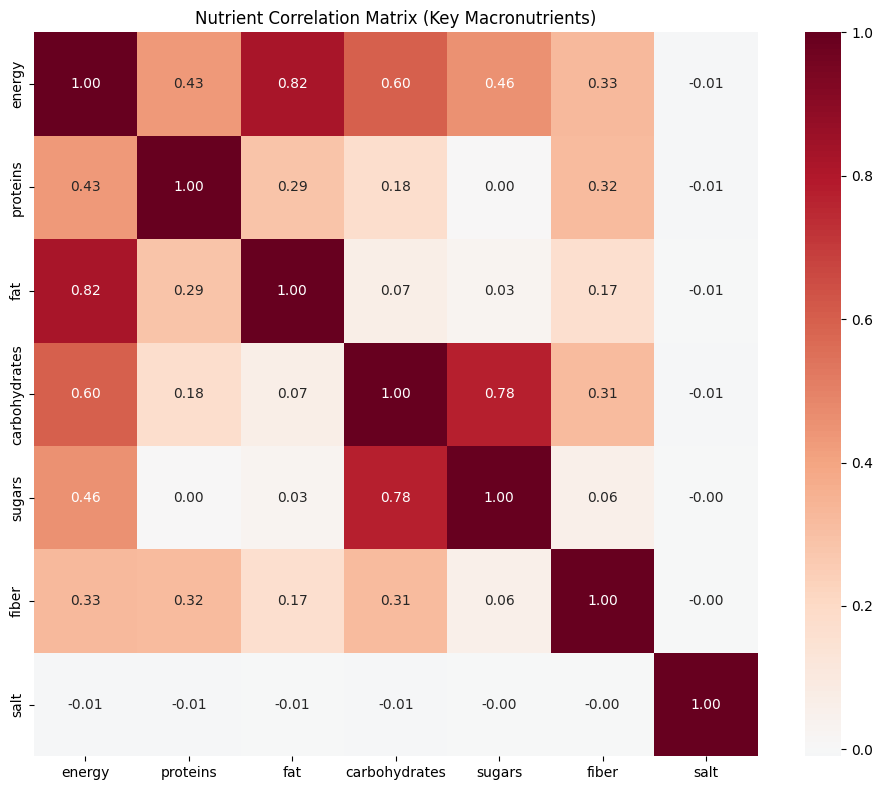

In [9]:
def analyze_nutrient_correlations(nutrients_df: pd.DataFrame, min_observations: int = 1000) -> Dict[str, Any]:
    """
    Analyze correlations between nutrients and create dependency maps
    """
    print(f"Analyzing nutrient correlations (min {min_observations} observations)...")
    
    # Filter nutrients with sufficient data
    sufficient_data_nutrients = []
    for col in nutrients_df.columns:
        if nutrients_df[col].notna().sum() >= min_observations:
            sufficient_data_nutrients.append(col)
    
    print(f"  Nutrients with sufficient data: {len(sufficient_data_nutrients)}")
    
    if len(sufficient_data_nutrients) < 2:
        print("  Insufficient data for correlation analysis")
        return {}
    
    # Create correlation matrix
    correlation_df = nutrients_df[sufficient_data_nutrients]
    correlation_matrix = correlation_df.corr()
    
    # Find strongest correlations
    correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            nutrient1 = correlation_matrix.columns[i]
            nutrient2 = correlation_matrix.columns[j]
            corr_val = correlation_matrix.iloc[i, j]
            
            if not pd.isna(corr_val):
                correlations.append({
                    'nutrient1': nutrient1,
                    'nutrient2': nutrient2,
                    'correlation': corr_val,
                    'abs_correlation': abs(corr_val)
                })
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: x['abs_correlation'], reverse=True)
    
    # Categorize correlations
    strong_positive = [c for c in correlations if c['correlation'] > 0.7]
    strong_negative = [c for c in correlations if c['correlation'] < -0.7]
    moderate_positive = [c for c in correlations if 0.5 < c['correlation'] <= 0.7]
    moderate_negative = [c for c in correlations if -0.7 <= c['correlation'] < -0.5]
    
    # Sort moderate correlations by correlation value (descending for positive, ascending for negative)
    moderate_positive.sort(key=lambda x: x['correlation'], reverse=True)
    moderate_negative.sort(key=lambda x: x['correlation'])
    
    analysis_results = {
        'correlation_matrix': correlation_matrix,
        'all_correlations': correlations,
        'strong_positive': strong_positive,
        'strong_negative': strong_negative,
        'moderate_positive': moderate_positive,
        'moderate_negative': moderate_negative,
        'nutrients_analyzed': sufficient_data_nutrients
    }
    
    return analysis_results

# Analyze nutrient correlations
if not nutrients_df.empty:
    correlation_analysis = analyze_nutrient_correlations(nutrients_df, min_observations=500)
    
    if correlation_analysis:
        print(f"\nNutrient Correlation Analysis Results:")
        print(f"="*60)
        
        print(f"Nutrients analyzed: {len(correlation_analysis['nutrients_analyzed'])}")
        print(f"Total correlations computed: {len(correlation_analysis['all_correlations'])}")
        
        # Show strongest positive correlations
        if correlation_analysis['strong_positive']:
            print(f"\nStrongest positive correlations (>0.7):")
            for i, corr in enumerate(correlation_analysis['strong_positive'][:10], 1):
                print(f"{i:2d}. {corr['nutrient1']:<40} ↔ {corr['nutrient2']:<20} | r={corr['correlation']:.3f}")
        
        # Show strongest negative correlations
        if correlation_analysis['strong_negative']:
            print(f"\nStrongest negative correlations (<-0.7):")
            for i, corr in enumerate(correlation_analysis['strong_negative'][:10], 1):
                print(f"{i:2d}. {corr['nutrient1']:<40} ↔ {corr['nutrient2']:<20} | r={corr['correlation']:.3f}")
        
        # Show top moderate positive correlations
        if correlation_analysis['moderate_positive']:
            print(f"\nTop 10 moderate positive correlations (0.5-0.7):")
            for i, corr in enumerate(correlation_analysis['moderate_positive'][:10], 1):
                print(f"{i:2d}. {corr['nutrient1']:<40} ↔ {corr['nutrient2']:<20} | r={corr['correlation']:.3f}")
        
        # Show top moderate negative correlations
        if correlation_analysis['moderate_negative']:
            print(f"\nTop 10 moderate negative correlations (-0.7 to -0.5):")
            for i, corr in enumerate(correlation_analysis['moderate_negative'][:10], 1):
                print(f"{i:2d}. {corr['nutrient1']:<40} ↔ {corr['nutrient2']:<20} | r={corr['correlation']:.3f}")
        
        # Show moderate correlations summary
        moderate_total = len(correlation_analysis['moderate_positive']) + len(correlation_analysis['moderate_negative'])
        print(f"\nTotal moderate correlations (0.5-0.7): {moderate_total}")
        print(f"  Positive moderate: {len(correlation_analysis['moderate_positive'])}")
        print(f"  Negative moderate: {len(correlation_analysis['moderate_negative'])}")
        
        # Visualize correlation matrix for key nutrients
        key_nutrients_for_viz = ['energy', 'proteins', 'fat', 'carbohydrates', 'sugars', 'fiber', 'salt']
        available_key_nutrients = [n for n in key_nutrients_for_viz if n in correlation_analysis['correlation_matrix'].columns]
        
        if len(available_key_nutrients) >= 3:
            print(f"\nCreating correlation visualization for key nutrients...")
            
            plt.figure(figsize=(10, 8))
            key_corr_matrix = correlation_analysis['correlation_matrix'][available_key_nutrients].loc[available_key_nutrients]
            
            sns.heatmap(key_corr_matrix, 
                       annot=True, 
                       cmap='RdBu_r', 
                       center=0,
                       square=True,
                       fmt='.2f')
            plt.title('Nutrient Correlation Matrix (Key Macronutrients)')
            plt.tight_layout()
            plt.show()
else:
    print("No nutritional data available for correlation analysis")

## 8. Missing Nutrient Imputation Strategies

In [10]:
def develop_imputation_strategies(nutrients_df: pd.DataFrame, main_df: pd.DataFrame) -> Dict[str, Any]:
    """
    Develop and test different imputation strategies for missing nutrients
    """
    print("Developing missing nutrient imputation strategies...")
    
    imputation_results = {}
    
    # 1. Analyze missing data patterns
    missing_patterns = nutrients_df.isnull()
    missing_counts = missing_patterns.sum()
    missing_percentages = (missing_counts / len(nutrients_df)) * 100
    
    print(f"  Missing data analysis completed")
    
    # 2. Category-based imputation analysis
    # Use food categories to inform imputation
    if 'categories' in main_df.columns:
        print(f"  Analyzing category-based imputation potential...")
        
        # Extract main food categories
        def extract_main_category(categories_str):
            if pd.isna(categories_str):
                return 'unknown'
            if isinstance(categories_str, str):
                # Split categories and take the first main category
                cats = categories_str.split(',')
                return cats[0].strip() if cats else 'unknown'
            return 'unknown'
        
        main_categories = main_df['categories'].apply(extract_main_category)
        
        # Analyze nutrient completeness by category
        category_completeness = {}
        for category in main_categories.value_counts().head(10).index:
            if category != 'unknown':
                category_mask = main_categories == category
                category_nutrients = nutrients_df[category_mask]
                
                if len(category_nutrients) >= 10:
                    completeness = (category_nutrients.notna().sum() / len(category_nutrients)) * 100
                    category_completeness[category] = {
                        'count': len(category_nutrients),
                        'avg_completeness': completeness.mean(),
                        'best_nutrients': completeness.nlargest(5).to_dict()
                    }
        
        imputation_results['category_analysis'] = category_completeness
    
    # 3. Test different imputation methods on a subset of complete data
    # Select nutrients with reasonable completeness for testing
    test_nutrients = missing_percentages[missing_percentages < 50].index.tolist()[:5]  # Top 5 most complete
    
    if test_nutrients:
        print(f"  Testing imputation methods on {len(test_nutrients)} nutrients...")
        
        imputation_methods = {}
        
        for nutrient in test_nutrients:
            nutrient_data = nutrients_df[nutrient].dropna()
            
            if len(nutrient_data) >= 100:
                # Create artificial missing data for testing
                test_data = nutrient_data.copy()
                n_missing = int(len(test_data) * 0.2)  # Remove 20% for testing
                missing_indices = np.random.choice(test_data.index, n_missing, replace=False)
                
                true_values = test_data.loc[missing_indices].copy()
                test_data.loc[missing_indices] = np.nan
                
                # Method 1: Mean imputation
                mean_imputed = test_data.fillna(test_data.mean())
                mean_mae = np.mean(np.abs(mean_imputed.loc[missing_indices] - true_values))
                
                # Method 2: Median imputation
                median_imputed = test_data.fillna(test_data.median())
                median_mae = np.mean(np.abs(median_imputed.loc[missing_indices] - true_values))
                
                # Method 3: Forward fill (using newer pandas method)
                ffill_imputed = test_data.ffill().fillna(test_data.mean())
                ffill_mae = np.mean(np.abs(ffill_imputed.loc[missing_indices] - true_values))
                
                imputation_methods[nutrient] = {
                    'mean_mae': mean_mae,
                    'median_mae': median_mae,
                    'ffill_mae': ffill_mae,
                    'best_method': min([('mean', mean_mae), ('median', median_mae), ('ffill', ffill_mae)], key=lambda x: x[1])[0]
                }
        
        imputation_results['method_comparison'] = imputation_methods
    
    # 4. Recommend imputation strategies based on missing percentage
    recommendations = {}
    
    for nutrient, missing_pct in missing_percentages.items():
        if missing_pct == 0:
            recommendations[nutrient] = 'no_imputation_needed'
        elif missing_pct < 10:
            recommendations[nutrient] = 'simple_imputation'  # Mean/median
        elif missing_pct < 30:
            recommendations[nutrient] = 'category_based_imputation'  # Use food categories
        elif missing_pct < 70:
            recommendations[nutrient] = 'advanced_imputation'  # KNN or ML-based
        else:
            recommendations[nutrient] = 'consider_exclusion'  # Too much missing data
    
    imputation_results['recommendations'] = recommendations
    imputation_results['missing_percentages'] = missing_percentages
    
    return imputation_results

# Develop imputation strategies
if not nutrients_df.empty:
    imputation_analysis = develop_imputation_strategies(nutrients_df, df)
    
    print(f"\nImputation Strategy Analysis:")
    print(f"="*50)
    
    # Show recommendations summary
    if 'recommendations' in imputation_analysis:
        rec_summary = pd.Series(imputation_analysis['recommendations']).value_counts()
        print(f"\nImputation recommendations summary:")
        for strategy, count in rec_summary.items():
            print(f"  {strategy.replace('_', ' ').title()}: {count} nutrients")
    
    # Show method comparison results
    if 'method_comparison' in imputation_analysis and imputation_analysis['method_comparison']:
        print(f"\nImputation method comparison (MAE - lower is better):")
        for nutrient, methods in list(imputation_analysis['method_comparison'].items())[:5]:
            print(f"\n{nutrient}:")
            print(f"  Mean: {methods['mean_mae']:.3f}")
            print(f"  Median: {methods['median_mae']:.3f}")
            print(f"  Forward Fill: {methods['ffill_mae']:.3f}")
            print(f"  Best method: {methods['best_method']}")
    
    # Category analysis results
    if 'category_analysis' in imputation_analysis:
        print(f"\nCategory-based imputation potential:")
        for category, analysis in list(imputation_analysis['category_analysis'].items())[:5]:
            print(f"\n{category} ({analysis['count']} products):")
            print(f"  Average completeness: {analysis['avg_completeness']:.1f}%")
else:
    print("No nutritional data available for imputation analysis")

Developing missing nutrient imputation strategies...
  Missing data analysis completed
  Analyzing category-based imputation potential...
  Testing imputation methods on 5 nutrients...

Imputation Strategy Analysis:

Imputation recommendations summary:
  Consider Exclusion: 48 nutrients
  Simple Imputation: 11 nutrients
  Category Based Imputation: 8 nutrients
  Advanced Imputation: 2 nutrients

Imputation method comparison (MAE - lower is better):

saturated-fat:
  Mean: 11.272
  Median: 8.708
  Forward Fill: 8.424
  Best method: ffill

sodium:
  Mean: 17.198
  Median: 12.486
  Forward Fill: 16.362
  Best method: median

salt:
  Mean: 24.801
  Median: 7.185
  Forward Fill: 12.275
  Best method: median

fat:
  Mean: 32.782
  Median: 25.734
  Forward Fill: 24.429
  Best method: ffill

carbohydrates:
  Mean: 60.602
  Median: 54.029
  Forward Fill: 48.726
  Best method: ffill

Category-based imputation potential:

undefined (35080 products):
  Average completeness: 39.5%

Plant-based food

## 9. Summary and Recommendations

In [13]:
def generate_nutritional_analysis_summary(nutrients_df, completeness_analysis, validation_results, nutritional_profiles, correlation_analysis, imputation_analysis):
    """
    Generate comprehensive summary of nutritional data mining analysis
    """
    print("="*70)
    print("NUTRITIONAL DATA MINING & PROCESSING SUMMARY")
    print("="*70)
    
    # Dataset overview
    if not nutrients_df.empty:
        print(f"\n📊 DATASET OVERVIEW:")
        print(f"   • Total products analyzed: {len(nutrients_df):,}")
        print(f"   • Unique nutrients extracted: {len(nutrients_df.columns)}")
        print(f"   • Memory usage: {nutrients_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        overall_completeness = (nutrients_df.notna().sum().sum() / (len(nutrients_df) * len(nutrients_df.columns))) * 100
        print(f"   • Overall nutritional completeness: {overall_completeness:.1f}%")
    
    # Completeness analysis
    if completeness_analysis and 'product_level' in completeness_analysis:
        print(f"\n🎯 NUTRITIONAL COMPLETENESS:")
        pl = completeness_analysis['product_level']
        print(f"   • Average product completeness: {pl['avg_completeness']:.1f}%")
        print(f"   • Highly complete products (≥80%): {pl['highly_complete']:,}")
        print(f"   • Sparsely complete products (<20%): {pl['sparsely_complete']:,}")
        
        if 'complete_macro_profiles' in completeness_analysis:
            cmp = completeness_analysis['complete_macro_profiles']
            print(f"   • Products with complete macro profiles: {cmp['count']:,} ({cmp['percentage']:.1f}%)")
    
    # Data quality
    if validation_results:
        print(f"\n✅ DATA QUALITY:")
        
        # Count nutrients with high outlier rates
        high_outlier_count = sum(1 for results in validation_results.values() 
                               if results.get('outliers_iqr_pct', 0) > 10)
        print(f"   • Nutrients with high outlier rates (>10%): {high_outlier_count}")
        
        # Count nutrients with negative values
        negative_value_count = sum(1 for results in validation_results.values() 
                                 if results.get('negative_values', 0) > 0)
        print(f"   • Nutrients with negative values: {negative_value_count}")
        
        # Show validation for key nutrients
        key_nutrients = ['energy', 'proteins', 'fat', 'carbohydrates']
        validated_key = [n for n in key_nutrients if n in validation_results]
        if validated_key:
            print(f"   • Key nutrients validated: {len(validated_key)}/{len(key_nutrients)}")
    
    # Nutritional profiles
    if not nutritional_profiles.empty:
        print(f"\n🍎 NUTRITIONAL PROFILES:")
        print(f"   • Profile features created: {len(nutritional_profiles.columns)}")
        
        if 'macro_profile' in nutritional_profiles.columns:
            macro_dist = nutritional_profiles['macro_profile'].value_counts()
            print(f"   • Macro profile distribution:")
            for profile in ['high_protein', 'high_fat', 'high_carb', 'balanced']:
                if profile in macro_dist.index:
                    count = macro_dist[profile]
                    pct = (count / len(nutritional_profiles)) * 100
                    print(f"     - {profile.replace('_', ' ').title()}: {count:,} ({pct:.1f}%)")
    
    # Correlation analysis
    if correlation_analysis and 'all_correlations' in correlation_analysis:
        print(f"\n🔗 NUTRIENT CORRELATIONS:")
        print(f"   • Nutrients analyzed: {len(correlation_analysis['nutrients_analyzed'])}")
        print(f"   • Total correlations computed: {len(correlation_analysis['all_correlations'])}")
        print(f"   • Strong positive correlations (>0.7): {len(correlation_analysis['strong_positive'])}")
        print(f"   • Strong negative correlations (<-0.7): {len(correlation_analysis['strong_negative'])}")
        print(f"   • Moderate correlations (0.5-0.7): {len(correlation_analysis['moderate_positive']) + len(correlation_analysis['moderate_negative'])}")
    
    # Imputation analysis
    if imputation_analysis and 'recommendations' in imputation_analysis:
        print(f"\n🔧 IMPUTATION STRATEGIES:")
        rec_summary = pd.Series(imputation_analysis['recommendations']).value_counts()
        
        for strategy, count in rec_summary.items():
            strategy_name = strategy.replace('_', ' ').title()
            print(f"   • {strategy_name}: {count} nutrients")
    
    # Key recommendations
    print(f"\n💡 KEY RECOMMENDATIONS:")
    
    if not nutrients_df.empty:
        high_quality_nutrients = (nutrients_df.notna().sum() / len(nutrients_df) > 0.5).sum()
        print(f"   • Focus on {high_quality_nutrients} nutrients with >50% completeness for analysis")
    
    if completeness_analysis and 'complete_macro_profiles' in completeness_analysis:
        cmp = completeness_analysis['complete_macro_profiles']
        print(f"   • Use {cmp['count']:,} products with complete macro profiles for meal planning")
    
    if validation_results:
        print(f"   • Implement outlier detection and data cleaning for production use")
    
    if imputation_analysis:
        print(f"   • Apply category-based imputation for nutrients with 10-30% missing data")
        print(f"   • Consider excluding nutrients with >70% missing data from core functionality")
    
    print(f"\n🚀 NEXT STEPS:")
    print(f"   1. Proceed with ingredient analysis (Analysis #3) - IMMEDIATE")
    print(f"   2. Implement integrated data optimization pipeline (combines type optimization + quality filtering)")
    print(f"   3. Create production-ready feature integration (nutritional + foundational profiles)")
    print(f"   4. Cross-validate analysis results between Analysis #1 and #2 findings")
    print(f"   5. Develop data preprocessing pipeline for NutriFoodBot production use")
    print(f"   6. Begin nutrient-based recommendation algorithm development")
    print(f"   7. Create nutritional similarity metrics for food substitution intelligence")
    
    print("\n" + "="*70)

# Generate comprehensive summary
generate_nutritional_analysis_summary(
    nutrients_df,
    completeness_analysis if 'completeness_analysis' in locals() else None,
    validation_results if 'validation_results' in locals() else None,
    nutritional_profiles if 'nutritional_profiles' in locals() else pd.DataFrame(),
    correlation_analysis if 'correlation_analysis' in locals() else None,
    imputation_analysis if 'imputation_analysis' in locals() else None
)

NUTRITIONAL DATA MINING & PROCESSING SUMMARY

📊 DATASET OVERVIEW:
   • Total products analyzed: 78,382
   • Unique nutrients extracted: 69
   • Memory usage: 41.3 MB
   • Overall nutritional completeness: 31.8%

🎯 NUTRITIONAL COMPLETENESS:
   • Average product completeness: 31.8%
   • Highly complete products (≥80%): 0
   • Sparsely complete products (<20%): 13,049
   • Products with complete macro profiles: 61,055 (77.9%)

✅ DATA QUALITY:
   • Nutrients with high outlier rates (>10%): 34
   • Nutrients with negative values: 9
   • Key nutrients validated: 4/4

🍎 NUTRITIONAL PROFILES:
   • Profile features created: 23
   • Macro profile distribution:
     - High Protein: 7,667 (9.8%)
     - High Fat: 10,773 (13.7%)
     - High Carb: 47,927 (61.1%)
     - Balanced: 12,015 (15.3%)

🔗 NUTRIENT CORRELATIONS:
   • Nutrients analyzed: 53
   • Total correlations computed: 1159
   • Strong positive correlations (>0.7): 85
   • Strong negative correlations (<-0.7): 0
   • Moderate correlations 

In [12]:
# Save processed data for next analysis
if not nutrients_df.empty:
    print("Saving processed nutritional data...")
    
    # Save extracted nutrients
    nutrients_df.to_parquet('processed_nutrients.parquet')
    print(f"  Saved extracted nutrients: {nutrients_df.shape}")
    
    # Save nutritional profiles
    if not nutritional_profiles.empty:
        nutritional_profiles.to_parquet('nutritional_profiles.parquet')
        print(f"  Saved nutritional profiles: {nutritional_profiles.shape}")
    
    # Save analysis results
    analysis_results = {
        'nutrient_categories': nutrient_categories if 'nutrient_categories' in locals() else {},
        'completeness_analysis': completeness_analysis if 'completeness_analysis' in locals() else {},
        'imputation_recommendations': imputation_analysis['recommendations'] if 'imputation_analysis' in locals() and 'recommendations' in imputation_analysis else {}
    }
    
    import json
    with open('nutritional_analysis_results.json', 'w') as f:
        # Convert numpy types to Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        # Recursively convert numpy types
        def convert_dict(d):
            if isinstance(d, dict):
                return {k: convert_dict(v) for k, v in d.items()}
            elif isinstance(d, list):
                return [convert_dict(v) for v in d]
            else:
                return convert_numpy(d)
        
        json.dump(convert_dict(analysis_results), f, indent=2)
    
    print(f"  Saved analysis results to JSON")
    
    print(f"\n✅ Analysis #2 (Nutritional Data Mining & Processing) completed successfully!")
    print(f"Ready to proceed with Analysis #3 (Ingredient Analysis & Food Substitution Intelligence)")
else:
    print("No nutritional data was extracted - check data format and availability")

Saving processed nutritional data...
  Saved extracted nutrients: (78382, 69)
  Saved nutritional profiles: (78382, 23)
  Saved analysis results to JSON

✅ Analysis #2 (Nutritional Data Mining & Processing) completed successfully!
Ready to proceed with Analysis #3 (Ingredient Analysis & Food Substitution Intelligence)
